In [214]:
!pip install Sastrawi

import pandas as pd
import numpy as np
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

from sklearn import svm

# import dataset

In [215]:
komentar = pd.read_csv('prabowo.csv')
komentar = komentar.drop_duplicates(subset=['full_text'])
komentar = komentar.dropna()
print(komentar.duplicated().sum())
print(komentar.isnull().sum())
# komentar.head(10)

0
Unnamed: 0             0
created_at             0
id_str                 0
full_text              0
quote_count            0
reply_count            0
retweet_count          0
favorite_count         0
lang                   0
user_id_str            0
conversation_id_str    0
username               0
tweet_url              0
dtype: int64


In [216]:
komentar.shape

(502, 13)

# cleansing

In [217]:
def cleaningkomentar(komentar):
  komentar = str(komentar)
  komentar = re.sub(r'#[A-Za-z0-9]+',' ',komentar)
  komentar = re.sub(r"http\S+",' ',komentar)
  komentar = re.sub(r'[0-9]+',' ',komentar)
  komentar = re.sub(r"[-()\"#/@;:<>{}'+=~|.!?,_]", " ", komentar)
  #menghapus karakter tunggal
  komentar = re.sub(r"\b[a-zA-Z]\b", " ", komentar)
  komentar = komentar.strip(' ')
  return komentar
komentar['cleansing']= komentar['full_text'].apply(cleaningkomentar)


def clearEmoji(ulasan):
    return ulasan.encode('ascii', 'ignore').decode('ascii')
komentar['remove_emojis']= komentar['cleansing'].apply(clearEmoji)

def replaceTOM(ulasan):
    pola = re.compile(r'(.)\1{2,}', re.DOTALL)
    return pola.sub(r'\1', ulasan)
komentar['cleansing']= komentar['remove_emojis'].apply(replaceTOM)

komentar[['full_text','cleansing']]
komentar[['full_text','cleansing']].to_csv('cleansing.csv', index=False,float_format='%.2f')

# case folding

In [218]:
def casefoldingText(komentar):
  komentar = str(komentar)
  komentar = komentar.lower()
  return komentar
komentar['case_folding']= komentar['cleansing'].apply(casefoldingText)
komentar[['cleansing','case_folding']]
komentar[['cleansing','case_folding']].to_csv('case_folding.csv', index=False)

# tokenizing

In [219]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
def tokenizingText(komentar):
  komentar = word_tokenize(komentar)
  return komentar
komentar['tokenizing']= komentar['case_folding'].apply(tokenizingText)
komentar[['case_folding','tokenizing']]
komentar[['case_folding','tokenizing']].to_csv('tokenizing.csv', index=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# stemming

In [220]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory


def stemming(kalimat_baru):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    # Lakukan stemming pada setiap kata
    stemmed_words = [stemmer.stem(word) for word in kalimat_baru]
    return stemmed_words

komentar['stemming_list'] = komentar['tokenizing'].apply(stemming)

#merubah list ke str
komentar['stemming'] = komentar['stemming_list'].apply(' '.join)

#menampilkan data hasil stemming
komentar[['tokenizing','stemming']]
komentar[['tokenizing','stemming']].to_csv('stemming.csv', index=False)

# negasi handling

In [221]:
def handle_negation(kalimat_baru):
    negation_words = ["tidak", "bukan", "tak", "tiada", "jangan", "gak", "ga"]
    new_words = []
    prev_word_is_negation = False
    for word in kalimat_baru:
        if word in negation_words:
            new_words.append("tidak_")
            prev_word_is_negation = True
        elif prev_word_is_negation:
            new_words[-1] += word
            prev_word_is_negation = False
        else:
            new_words.append(word)
    return new_words
komentar['negation'] = komentar['stemming_list'].apply(handle_negation)
#menampilkan data hasil stemming
komentar[['stemming','negation']]
komentar[['stemming','negation']].to_csv('negation.csv', index=False)

# word normalization

In [222]:
def convertToSlangword(komentar):
    kamusSlang = eval(open("slangwords.txt").read())
    pattern = re.compile(r'\b( ' + '|'.join (kamusSlang.keys())+r')\b')
    content = []
    for kata in komentar:
        filter_slang = pattern.sub(lambda x: kamusSlang[x.group()], kata.lower())
        if filter_slang.startswith('tidak_'):
          kata_depan = 'tidak_'
          kata_belakang = kata[6:]
          kata_belakang_slang = pattern.sub(lambda x: kamusSlang[x.group()], kata_belakang.lower())
          kata_hasil = kata_depan + kata_belakang_slang
          content.append(kata_hasil)
        else:
          content.append(filter_slang)
    komentar = content
    return komentar

komentar['formalization'] = komentar['negation'].apply(convertToSlangword)
komentar[['negation','formalization']]
komentar[['negation','formalization']].to_csv('normalization.csv', index=False)

# stopword removal

In [223]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Mengunduh daftar stopword dari NLTK
daftar_stopword = stopwords.words('indonesian')

# Menambahkan stopword tambahan
daftar_stopword.extend(["yg", "dg", "rt", "dgn", "ny", "d",'gb','ahk','g'])

# Membaca file teks stopword menggunakan pandas
txt_stopword = pd.read_csv("stopwords.txt", names=["stopwords"], header=None)

# Menggabungkan daftar stopword dari NLTK dengan daftar stopword dari file teks
daftar_stopword.extend(txt_stopword['stopwords'].tolist())

# Mengubah daftar stopword menjadi set untuk pencarian yang lebih efisien
daftar_stopword = set(daftar_stopword)

def stopwordText(words):
    cleaned_words = []
    for word in words:
        # Memisahkan kata dengan tambahan "tidak_"
        if word.startswith("tidak_"):
            cleaned_words.append(word[:5])
            cleaned_words.append(word[6:])
        elif word not in daftar_stopword:
            cleaned_words.append(word)
    return cleaned_words

komentar['stopword_list'] = komentar['formalization'].apply(stopwordText)
#merubah list ke str
komentar['stopword_removal'] = komentar['stopword_list'].apply(' '.join)
komentar[['formalization','stopword_removal']].to_csv('stopwords.csv', index=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Save Clean Dataset

In [224]:
komentar.to_csv('clean_dataset.csv',index=False)

In [225]:
data = pd.read_csv('clean_dataset.csv')
data = data[data['tokenizing'] != '[]']
data = data[data['stopword_list'] != '[]']
data = data.drop(['Unnamed: 0'], axis=1, inplace = False)
data = data.drop_duplicates(subset=['stopword_removal'])
data = data.dropna()
print(data['stopword_removal'].duplicated().sum())
print(data.isnull().sum())
data.to_csv('clean_dataset.csv',index=False)

0
created_at             0
id_str                 0
full_text              0
quote_count            0
reply_count            0
retweet_count          0
favorite_count         0
lang                   0
user_id_str            0
conversation_id_str    0
username               0
tweet_url              0
cleansing              0
remove_emojis          0
case_folding           0
tokenizing             0
stemming_list          0
stemming               0
negation               0
formalization          0
stopword_list          0
stopword_removal       0
dtype: int64


# Translate

In [228]:
#Install Library Googletrans
!pip3 install googletrans==3.1.0a0
import googletrans
from googletrans import *
translator = googletrans.Translator()
df = pd.read_csv('clean_dataset.csv')
# df['stopword_removal'] = df['stopword_removal'].astype(str) #Ubah tipe data ke string
df['english_comment'] = df['stopword_removal'].apply(translator.translate, src='auto', dest='en').apply(getattr, args=('text',))
df
#Simpan data terjemahan inggris ke file csv
df.to_csv('clean_dataset_en.csv')

# VADER and Classification

In [229]:
import pandas as pd
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Inisialisasi SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Fungsi untuk mendapatkan label berdasarkan nilai sentimen
def get_sentiment_label(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Membaca file CSV dengan kolom 'ulasan'
data = pd.read_csv('clean_dataset_en.csv')

# Membuat kolom baru untuk menyimpan hasil pelabelan
data['vader_sentiment'] = ""

# Melakukan pelabelan pada setiap ulasan
for index, row in data.iterrows():
    komentar = row['english_comment']
    sentiment_score = sia.polarity_scores(komentar)['compound']
    label = get_sentiment_label(sentiment_score)
    data.at[index, 'vader_sentiment'] = label

# Menyimpan hasil pelabelan ke file CSV
output_path = 'vader_sentiment_results.csv'  # Ganti dengan path tujuan Anda
data.to_csv(output_path, index=False)

print("Pelabelan selesai. Hasil disimpan di:", output_path)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Pelabelan selesai. Hasil disimpan di: vader_sentiment_results.csv


# Visualization

jumlah sentimen :
positive    248
negative    110
neutral      94
Name: vader_sentiment, dtype: int64


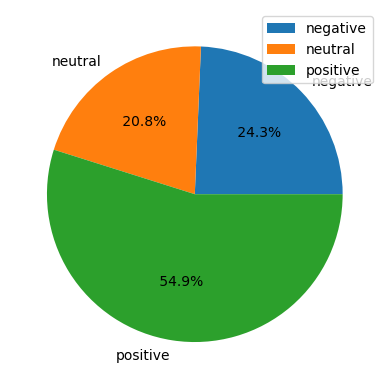

In [230]:
# melihat jumlah kelas sentimen
komentar = pd.read_csv('vader_sentiment_results.csv')
Jumlah_sentimen = komentar['vader_sentiment'].value_counts()
print("jumlah sentimen :")
print(Jumlah_sentimen)
# menampilkan dalam bentuk plot diagram
import matplotlib.pyplot as plt
%matplotlib inline
labels = ['negative' , 'neutral', 'positive']
plt.pie(komentar.groupby('vader_sentiment')['vader_sentiment'].count(), autopct=" %.1f%% " ,labels=labels)
plt.legend()
plt.show()

# Negatif Sentimen

In [231]:
# Membuat DataFrame baru hanya dengan sentimen negatif
sentimen_negatif = komentar[komentar['vader_sentiment'] == 'negative']

# Menyimpan DataFrame baru ke dalam file CSV jika diperlukan
sentimen_negatif.to_csv('prabowo_negative_sentiments.csv', index=False)

# Wordcloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


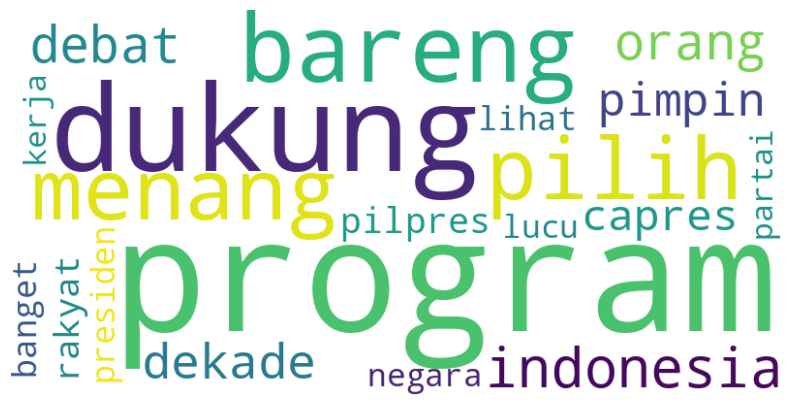

Kata: 'program', Jumlah Kemunculan: 100
Kata: 'dukung', Jumlah Kemunculan: 52
Kata: 'bareng', Jumlah Kemunculan: 50
Kata: 'menang', Jumlah Kemunculan: 41
Kata: 'pilih', Jumlah Kemunculan: 41
Kata: 'indonesia', Jumlah Kemunculan: 37
Kata: 'debat', Jumlah Kemunculan: 30
Kata: 'orang', Jumlah Kemunculan: 30
Kata: 'dekade', Jumlah Kemunculan: 28
Kata: 'pimpin', Jumlah Kemunculan: 26
Kata: 'capres', Jumlah Kemunculan: 23
Kata: 'pilpres', Jumlah Kemunculan: 22
Kata: 'rakyat', Jumlah Kemunculan: 21
Kata: 'lihat', Jumlah Kemunculan: 19
Kata: 'banget', Jumlah Kemunculan: 19
Kata: 'presiden', Jumlah Kemunculan: 19
Kata: 'lucu', Jumlah Kemunculan: 18
Kata: 'negara', Jumlah Kemunculan: 18
Kata: 'partai', Jumlah Kemunculan: 17
Kata: 'kerja', Jumlah Kemunculan: 17


In [243]:
from tkinter import END
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter

def generate_wordcloud(text):
  global WordCloud
  global stopwords
  global Counter

  # Mengunduh daftar stopword dari NLTK
  daftar_stopword = stopwords.words('indonesian')

  # Menambahkan stopword tambahan
  stopwords_nltk = set(STOPWORDS)
  daftar_stopword.extend(["yg", "dg", "rt", "dgn", "ny", "d",'gb','ahk',
                          'g','nya','online', 'ratih', 'dm','aamiin',
                          'olivia', 'daesang', 'iya', 'views', 'gaco',
                          'partaisocmed', 'batter', 'mas', 'nan', 'mrk', 'sih',
                          'anies', 'baswedan', 'ganjar', 'aniesbaswedan', 'prabowo',
                          'jokowi', 'andre', 'ginting', 'lady', 'adidas', 'vivacoid',
                          'moldova', 'gp', 'pranowo', 'mahfud', 'md', 'inkindo', 'tuju',
                          'ra', 'perkasahabsyah', 'ri', 'prioritaspragibs', 'gibran',
                          'ahy', 'yulianidiya', 'tweet', 'gerindra', 'agusyudhoyono',
                          'pdemokrat', 'demokrat', 'rosiade', 'bengkeldodo', 'gin',
                          'gen', 'id', 'bang', 'deh'])
  daftar_stopword.extend(stopwords_nltk)

  # Membaca file teks stopword menggunakan pandas
  txt_stopword = pd.read_csv("stopwords.txt", names=["stopwords"], header=None)

  # Menggabungkan daftar stopword dari NLTK dengan daftar stopword dari file teks
  daftar_stopword.extend(txt_stopword['stopwords'].tolist())

  # Membagi teks menjadi kata-kata atau token
  text = text.split()

  # Menghitung frekuensi setiap kata
  final_text = Counter(text)

  # Menghapus stopwords dari data Counter
  final_text = {kata: jumlah for kata, jumlah in final_text.items() if kata.lower() not in daftar_stopword}

  # Mengambil 20 term tertinggi
  top_20_kata = Counter(final_text).most_common(20)

  # Membuat WordCloud dengan menggunakan Counter setelah stopwords dihilangkan
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_20_kata))

  # Menampilkan WordCloud
  plt.figure(figsize=(10, 8))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

    # Cetak 20 term tertinggi beserta jumlah kemunculannya
  for kata, jumlah in top_20_kata:
    print(f"Kata: '{kata}', Jumlah Kemunculan: {jumlah}")




# Menggabungkan semua kata pada kolom finalisasi komentar (Stopword_removal) menjadi satu teks
text = ' '.join(komentar['stopword_removal'].astype(str).values)

generate_wordcloud(text)



# Positive Sentiments Wordcloud

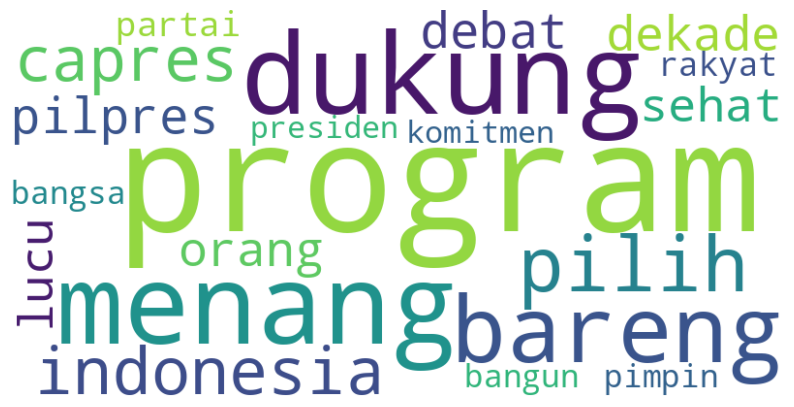

Kata: 'program', Jumlah Kemunculan: 84
Kata: 'dukung', Jumlah Kemunculan: 39
Kata: 'menang', Jumlah Kemunculan: 38
Kata: 'bareng', Jumlah Kemunculan: 38
Kata: 'pilih', Jumlah Kemunculan: 25
Kata: 'indonesia', Jumlah Kemunculan: 20
Kata: 'capres', Jumlah Kemunculan: 18
Kata: 'pilpres', Jumlah Kemunculan: 18
Kata: 'debat', Jumlah Kemunculan: 18
Kata: 'orang', Jumlah Kemunculan: 17
Kata: 'dekade', Jumlah Kemunculan: 17
Kata: 'sehat', Jumlah Kemunculan: 16
Kata: 'lucu', Jumlah Kemunculan: 16
Kata: 'partai', Jumlah Kemunculan: 15
Kata: 'rakyat', Jumlah Kemunculan: 13
Kata: 'pimpin', Jumlah Kemunculan: 12
Kata: 'bangsa', Jumlah Kemunculan: 12
Kata: 'bangun', Jumlah Kemunculan: 12
Kata: 'komitmen', Jumlah Kemunculan: 11
Kata: 'presiden', Jumlah Kemunculan: 11


In [244]:
# Membuat subset dari DataFrame 'komentar' dengan sentimen positif
komentar_positif = komentar[komentar['vader_sentiment'] == 'positive']
text = ' '.join(komentar_positif['stopword_removal'].astype(str).values)

generate_wordcloud(text)

# Netral Sentiments Wordcloud

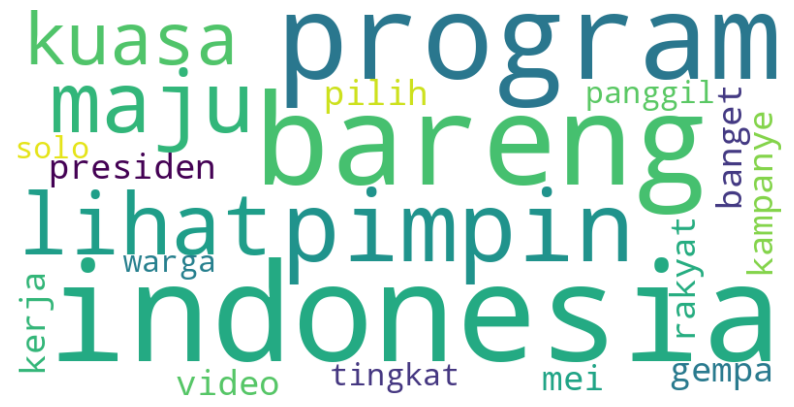

Kata: 'indonesia', Jumlah Kemunculan: 13
Kata: 'bareng', Jumlah Kemunculan: 11
Kata: 'program', Jumlah Kemunculan: 10
Kata: 'pimpin', Jumlah Kemunculan: 8
Kata: 'lihat', Jumlah Kemunculan: 6
Kata: 'maju', Jumlah Kemunculan: 6
Kata: 'kuasa', Jumlah Kemunculan: 5
Kata: 'presiden', Jumlah Kemunculan: 4
Kata: 'kampanye', Jumlah Kemunculan: 4
Kata: 'banget', Jumlah Kemunculan: 4
Kata: 'gempa', Jumlah Kemunculan: 4
Kata: 'rakyat', Jumlah Kemunculan: 4
Kata: 'pilih', Jumlah Kemunculan: 4
Kata: 'mei', Jumlah Kemunculan: 4
Kata: 'kerja', Jumlah Kemunculan: 4
Kata: 'video', Jumlah Kemunculan: 4
Kata: 'tingkat', Jumlah Kemunculan: 3
Kata: 'warga', Jumlah Kemunculan: 3
Kata: 'panggil', Jumlah Kemunculan: 3
Kata: 'solo', Jumlah Kemunculan: 3


In [245]:
# Membuat subset dari DataFrame 'komentar' dengan sentimen netral
komentar_netral = komentar[komentar['vader_sentiment'] == 'neutral']
text = ' '.join(komentar_netral['stopword_removal'].astype(str).values)

generate_wordcloud(text)

# Negative Sentiments Wordcloud

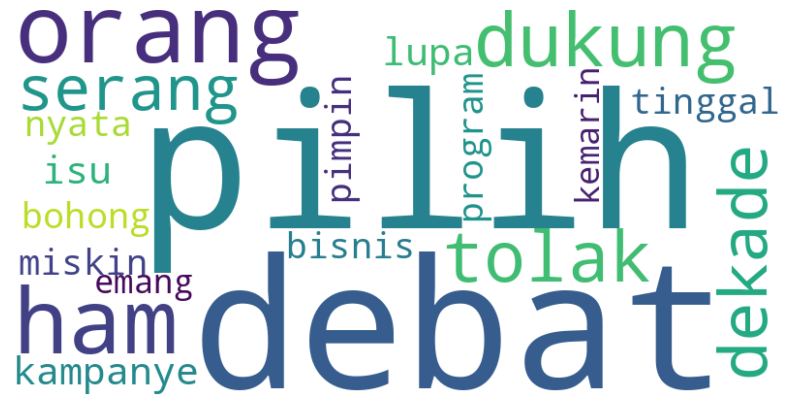

Kata: 'pilih', Jumlah Kemunculan: 12
Kata: 'debat', Jumlah Kemunculan: 11
Kata: 'orang', Jumlah Kemunculan: 11
Kata: 'ham', Jumlah Kemunculan: 10
Kata: 'dukung', Jumlah Kemunculan: 10
Kata: 'tolak', Jumlah Kemunculan: 9
Kata: 'dekade', Jumlah Kemunculan: 8
Kata: 'serang', Jumlah Kemunculan: 7
Kata: 'kampanye', Jumlah Kemunculan: 7
Kata: 'isu', Jumlah Kemunculan: 7
Kata: 'lupa', Jumlah Kemunculan: 7
Kata: 'bohong', Jumlah Kemunculan: 6
Kata: 'tinggal', Jumlah Kemunculan: 6
Kata: 'bisnis', Jumlah Kemunculan: 6
Kata: 'miskin', Jumlah Kemunculan: 6
Kata: 'pimpin', Jumlah Kemunculan: 6
Kata: 'nyata', Jumlah Kemunculan: 6
Kata: 'program', Jumlah Kemunculan: 6
Kata: 'emang', Jumlah Kemunculan: 5
Kata: 'kemarin', Jumlah Kemunculan: 5


In [246]:
# Membuat subset dari DataFrame 'komentar' dengan sentimen negatif
komentar_negatif = komentar[komentar['vader_sentiment'] == 'negative']
text = ' '.join(komentar_negatif['stopword_removal'].astype(str).values)

generate_wordcloud(text)

In [247]:
# komentar[['full_text', 'vader_sentiment']]
komentar

,Unnamed: 0,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,...,case_folding,tokenizing,stemming_list,stemming,negation,formalization,stopword_list,stopword_removal,english_comment,vader_sentiment
0,0,Fri Dec 15 04:10:46 +0000 2023,1735512698522382615,"@andre_rosiade eh botak, bilang ke capres lu d...",0,0,0,0,in,1718575798792355840,...,andre rosiade eh botak bilang ke capres lu du...,"['andre', 'rosiade', 'eh', 'botak', 'bilang', ...","['andre', 'rosiade', 'eh', 'botak', 'bilang', ...",andre rosiade eh botak bilang ke capres lu dul...,"['andre', 'rosiade', 'eh', 'botak', 'bilang', ...","['andre', 'rosiade', 'eh', 'botak', 'bilang', ...","['andre', 'rosiade', 'eh', 'botak', 'bilang', ...",andre rosiade eh botak bilang capres ngobrol a...,"Andre Rosiade, eh bald, said the presidential ...",positive
1,1,Fri Dec 15 04:10:46 +0000 2023,1735512698086166538,"Elektabilitas tembus 45 persen, AHY: Prabowo b...",0,0,0,0,in,1101762919,...,elektabilitas tembus persen ahy prabowo bisa...,"['elektabilitas', 'tembus', 'persen', 'ahy', '...","['elektabilitas', 'tembus', 'persen', 'ahy', '...",elektabilitas tembus persen ahy prabowo bisa m...,"['elektabilitas', 'tembus', 'persen', 'ahy', '...","['elektabilitas', 'tembus', 'persen', 'ahy', '...","['elektabilitas', 'tembus', 'persen', 'ahy', '...",elektabilitas tembus persen ahy prabowo menang...,electability reaches percent ahy prabowo wins ...,positive
2,2,Fri Dec 15 04:10:43 +0000 2023,1735512687281573985,"Beri pujian ke AHY, Prabowo: Pemimpin yang heb...",0,0,0,0,in,1101762919,...,beri pujian ke ahy prabowo pemimpin yang heb...,"['beri', 'pujian', 'ke', 'ahy', 'prabowo', 'pe...","['beri', 'puji', 'ke', 'ahy', 'prabowo', 'pimp...",beri puji ke ahy prabowo pimpin yang hebat unt...,"['beri', 'puji', 'ke', 'ahy', 'prabowo', 'pimp...","['beri', 'puji', 'ke', 'ahy', 'prabowo', 'pimp...","['puji', 'ahy', 'prabowo', 'pimpin', 'hebat', ...",puji ahy prabowo pimpin hebat bangsa indonesia...,Praise Ahy Prabowo for the great leadership of...,positive
3,3,Fri Dec 15 04:10:41 +0000 2023,1735512676552597739,@kurawa jokowi hebat....setuju tapi melihat pe...,0,0,0,0,in,1069905602,...,kurawa jokowi hebat setuju tapi melihat penamp...,"['kurawa', 'jokowi', 'hebat', 'setuju', 'tapi'...","['rawa', 'jokowi', 'hebat', 'tuju', 'tapi', 'l...",rawa jokowi hebat tuju tapi lihat tampil prabo...,"['rawa', 'jokowi', 'hebat', 'tuju', 'tapi', 'l...","['rawa', 'jokowi', 'hebat', 'tuju', 'tapi', 'l...","['rawa', 'jokowi', 'hebat', 'tuju', 'lihat', '...",rawa jokowi hebat tuju lihat tampil prabowo de...,Rawa Jokowi is great to see Prabowo appear in ...,positive
4,4,Fri Dec 15 04:10:38 +0000 2023,1735512663923490883,Prabowo prediksi AHY akan jadi pemimpin di tin...,0,0,0,0,in,1101762919,...,prabowo prediksi ahy akan jadi pemimpin di tin...,"['prabowo', 'prediksi', 'ahy', 'akan', 'jadi',...","['prabowo', 'prediksi', 'ahy', 'akan', 'jadi',...",prabowo prediksi ahy akan jadi pimpin di tingk...,"['prabowo', 'prediksi', 'ahy', 'akan', 'jadi',...","['prabowo', 'prediksi', 'ahy', 'akan', 'jadi',...","['prabowo', 'prediksi', 'ahy', 'pimpin', 'ting...",prabowo prediksi ahy pimpin tingkat nasional ...,Prabowo predicts Ahy will lead FC national lev...,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,447,Fri Dec 15 03:56:02 +0000 2023,1735508992292761617,"@kompascom Memang tidak mudah, sekarang masyar...",0,1,0,0,in,117907590,...,kompascom memang tidak mudah sekarang masyara...,"['kompascom', 'memang', 'tidak', 'mudah', 'sek...","['kompascom', 'memang', 'tidak', 'mudah', 'sek...",kompascom memang tidak mudah sekarang masyarak...,"['kompascom', 'memang', 'tidak_mudah', 'sekara...","['kompascom', 'memang', 'tidak_mudah', 'sekara...","['kompascom', 'tidak', 'mudah', 'masyarakat', ...",kompascom tidak mudah masyarakat gagas ide kon...,"Kompascom, it's not easy for people to come up...",negative
448,448,Fri Dec 15 03:56:01 +0000 2023,1735508988

# **Accuracy**


In [ ]:
##TODO##

In [250]:
!zip -r /content/prabowo.zip /content/prabowo

  adding: content/prabowo/ (stored 0%)
  adding: content/prabowo/clean_dataset_en.csv (deflated 83%)
  adding: content/prabowo/case_folding.csv (deflated 76%)
  adding: content/prabowo/vader_sentiment_results.csv (deflated 83%)
  adding: content/prabowo/stemming.csv (deflated 73%)
  adding: content/prabowo/prabowo_negative_sentiments.csv (deflated 82%)
  adding: content/prabowo/stopwords.csv (deflated 75%)
  adding: content/prabowo/tokenizing.csv (deflated 72%)
  adding: content/prabowo/cleansing.csv (deflated 75%)
  adding: content/prabowo/clean_dataset.csv (deflated 85%)
  adding: content/prabowo/normalization.csv (deflated 84%)
  adding: content/prabowo/negation.csv (deflated 72%)
